# CVAE Interpretability Analysis

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Implementation of a Conditional Variational Autoencoder (CVAE) including data preparation, training and evaluation.

**Dependencies**: 
- `CVAE.py`
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`
- `Saved Models\DNN_Model_Full_V3\DNN_Model_Full_V3.pth`
- `Saved Models\CVAE_Model_V1\CVAE_Model_V1.pth`
- `Saved Variables\hypercubemap.npy`
- `Saved Variables\interaction_kmeans.pkl`
- `Saved Variables\interaction_pca.pkl`


**Generates**:


## Setup

### Import

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import os
import pickle

from xgboost import XGBRegressor

import importlib

from DataReader import DataReader
from Settings import Directory, Plotting_Parameters
from DNN import DNN
from CVAE import CVAE
from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
# Presentation Settigs
plot_params.params['figure.dpi']=300
plot_params.update()

### Load Data

In [4]:
datareader = DataReader()
df_full = datareader.load('Knee_Connection_Output_red.csv')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


### Load Models

In [5]:
forward_model_name = 'DNN_Model_Full_V3'
MODEL_FORWARD_SAVE_FILE = rf"Saved Models\{forward_model_name}\{forward_model_name}.pth"

model_forward = torch.load(MODEL_FORWARD_SAVE_FILE)

In [8]:
inverse_model_name = 'CVAE_Model_V1'
MODEL_INVERSE_SAVE_FILE = rf"Saved Models\{inverse_model_name}\{inverse_model_name}.pth"

model = torch.load(MODEL_INVERSE_SAVE_FILE)

### Define features and conditions

In [9]:
features = model.features
conditions = model.conditions

## Sampling

In [ ]:
ids = random.choices(range(len(df_full)), k=1000)
df_choices = df_full.iloc[ids].copy()

### Functions for generating metrics

#### Reconstruction error

In [ ]:
def get_determinstic_sample(model,base_sample):
    x = base_sample[features].values.reshape(1, -1)
    y = base_sample[conditions].values.reshape(1, -1)

    x_std = model.scaler_x.transform(x)
    y_std = model.scaler_y.transform(y)

    x_tensor = torch.tensor(x_std, dtype=torch.float32)
    y_tensor = torch.tensor(y_std, dtype=torch.float32)

    mu, logvar = model.encoder(x_tensor, y_tensor)
    z = mu
    x_recon_std = model.decoder(z, y_tensor).detach().numpy()
    x_recon = model.scaler_x.inverse_transform(x_recon_std)

    return x_recon, x

#### Clipping samples to real values

In [ ]:
def clip(profiles_sampled, df, features, categorical_threshold=10_000):
    profiles_sampled_clipped = profiles_sampled.copy()

    for feature in features:
        if feature in profiles_sampled.columns:
            if df[feature].nunique() < categorical_threshold:

                valid_values = np.sort(df[feature].unique())

                def closest_value(x):
                    idx = np.searchsorted(valid_values, x, side="left")
                    if idx == 0:
                        return valid_values[0]
                    if idx == len(valid_values):
                        return valid_values[-1]
                    lower = valid_values[idx - 1]
                    upper = valid_values[idx]
                    return upper if abs(upper - x) < abs(lower - x) else lower

                profiles_sampled_clipped[feature] = profiles_sampled_clipped[feature].apply(closest_value)

    return profiles_sampled_clipped

#### Wobbliness

In [ ]:
def calculate_wonkyness(x_coords, y_coords):
    angles = []
    for i in range(len(x_coords) - 2):
        # Define the three consecutive points
        p1 = np.array([x_coords[i], y_coords[i]])
        p2 = np.array([x_coords[i+1], y_coords[i+1]])
        p3 = np.array([x_coords[i+2], y_coords[i+2]])

        # Vector of the first segment (p2 - p1)
        v1 = p2 - p1
        # Vector of the second segment (p3 - p2)
        v2 = p3 - p2

        # Calculate the angle between the two vectors using the dot product
        dot_product = np.dot(v1, v2)
        magn_v1 = np.linalg.norm(v1)
        magn_v2 = np.linalg.norm(v2)

        cos_theta = dot_product / (magn_v1 * magn_v2)
        # Ensure cos_theta is within the valid range [-1, 1] due to potential floating-point errors
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        angle = np.arccos(cos_theta)

        angles.append(angle)

    return np.std(angles)

#### Feasibility

In [ ]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None

    bin_indices = np.zeros(len(datapoint), dtype=int)
    nonzero_mask = bin_widths > 0

    bin_indices[nonzero_mask] = ((datapoint[nonzero_mask] - bounds[nonzero_mask][:, 0]) / (bin_widths[nonzero_mask])).astype(int)
    bin_indices[nonzero_mask] = np.clip(bin_indices[nonzero_mask], 0, m - 1)
    
    return tuple(bin_indices)

def check_feasibility(datapoint, hypercubemap, bounds, m):
    bin_indices = find_bins(datapoint, bounds, m)

    if bin_indices is None:
        return 'Datapoint is out of bounds'
    
    closest_index = np.argmin(np.sum((hypercubemap - bin_indices) ** 2, axis=1))
    closest_bin = hypercubemap[closest_index]
    error = np.abs(closest_bin - bin_indices)

    feasibilty_degree = np.max(error)

    return feasibilty_degree, np.sum(error)/len(error)

#### Clustering

In [ ]:
def normalize_curve(points):
    points = np.array(points)
    max_val = np.max(points) #max_vals = np.max(points, axis=0) (Both axes fixed on (1,0), (1,0)
    return points / max_val

def resample_curve(points, num_points=100):
    points = np.array(points)
    dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    dist = np.insert(dist, 0, 0)
    uniform_dist = np.linspace(0, dist[-1], num_points)
    interp_func = interp1d(dist, points, axis=0)
    return interp_func(uniform_dist)

def flatten_curve(points):
    return points.flatten()

def preprocess_curves(curves, num_points=100):
    return [flatten_curve(resample_curve(normalize_curve(c), num_points)) for c in curves]

def assign_new_data_to_clusters(new_curves, pca, kmeans):
    new_data = preprocess_curves(new_curves)
    reduced_new_data = pca.transform(new_data)
    cluster_labels = kmeans.predict(reduced_new_data)
    distances = np.min(kmeans.transform(reduced_new_data), axis=1)
    silhouette_avg = silhouette_score(reduced_new_data, cluster_labels)
    
    return cluster_labels, distances, silhouette_avg

#### Get Variables

In [ ]:
with open("Saved Variables\hypercube_features.json", "rb") as file: 
       hypercube_features = pickle.load(file)

hypercubemap = np.load(r"Saved Variables\hypercubemap.npy")

In [ ]:
with open(r"Saved Variables\interaction_pca.pkl", "rb") as file:
    pca = pickle.load(file)

with open(r"Saved Variables\interaction_kmeans.pkl", "rb") as file:
    kmeans = pickle.load(file)

## Get metrics

### Reconstruction deviation

In [25]:
reconstruction_deviation = []

upper_bounds = df_full[features].max().values
for i, base_sample in df_choices.iterrows():
    x_recon, x_input = get_determinstic_sample(model,base_sample)

    rel_deviation = (x_recon[0] - (x_input[0])) / upper_bounds
    reconstruction_deviation.append(rel_deviation)

reconstruction_deviation = np.array(reconstruction_deviation)

NameError: name 'df_choices' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for i,feature in enumerate(features):
    error = reconstruction_deviation[:,i]

    error_bin_mean = error.mean()

    confidence = 50
    error_lower_val = np.percentile(error, (100 - confidence) / 2)
    error_upper_val = np.percentile(error, confidence + (100 - confidence) / 2)

    error_lower_bound = np.abs(error_bin_mean - error_lower_val)
    error_upper_bound = np.abs(error_upper_val - error_bin_mean)

    error_bounds = np.array([[error_lower_bound], [error_upper_bound]])

    ax.text(i-0.1, error_bin_mean-0.005, f"{error_bin_mean*100:.2f}+{error_upper_bound*100:.2f}-{error_lower_bound*100:.2f}%", ha='center', va='bottom', fontsize=10, color=plot_params.colors[3], rotation=90)
    ax.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', color=plot_params.colors[3], markersize=5, capsize=6)

ax.set_ylabel('Error / Max Value in Feature  [%]')
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=45)
ax.hlines(y=0, xmin=-0.5, xmax=len(features)-0.5, color='k', linestyle='--', label='Original')

plt.grid(True, axis='y', which='both', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

### Get MV-Interaction metrics from samples & base

In [ ]:
bounds = np.array([df_full[hypercube_features].min(), df_full[hypercube_features].max()]).T
m = int(np.max(hypercubemap))
bin_widths = (bounds[:, 1] - bounds[:, 0]) / m

In [ ]:
n_samples = 20
sample_interaction_error = np.zeros((len(ids), n_samples))
sample_uncertainty = np.zeros((len(ids), n_samples))
sample_wonkyness = np.zeros((len(ids), n_samples))
sample_average_infeasibilities = np.zeros((len(ids), n_samples))
sample_feasibility_degrees = np.zeros((len(ids), n_samples))
base_interaction_curve_MRd = np.zeros((len(ids), 20))
base_interaction_curve_VRd = np.zeros((len(ids), 20))

for i,id in enumerate(ids):
    base_sample = df_choices.iloc[i:i+1].copy()

    if i % 10 == 0:
        print(f"{i/len(df_choices):.2%}")
    
    # Generate a base sample with the same features as the original sample
    generated_samples = pd.concat([base_sample]*n_samples, ignore_index=True)
    generated_features = model.sample(base_sample, n_samples=n_samples, sample_distance_factor=1.0)
    generated_samples[features] = generated_features.values

    # Clip the generated samples to ensure they are within the bounds of the original data
    generated_samples = clip(generated_samples, df_full, features)

    # With forward model get the interaction curve of the base sample
    MRd_samples = np.zeros((n_samples, 20))
    VRd_samples = np.zeros((n_samples, 20))
    MRd_base, VRd_base, _ = model_forward.get_MV_interaction_prediction(base_sample.iloc[0],20)
    base_interaction_curve_MRd[i] = MRd_base
    base_interaction_curve_VRd[i] = VRd_base

    # Get uncertainty of samples
    mcd_mean, mcd_std, _ = model_forward.mc_dropout_uncertainty(generated_samples, num_samples=20)
    uncertainty = mcd_std / mcd_mean
    sample_uncertainty[i] = uncertainty.flatten()

    error = np.zeros(n_samples)
    wonkyness = np.zeros(n_samples)

    for k,sample in generated_samples.iterrows():
        # Get the interaction curve of the generated samples
        MRd_sample, VRd_sample, _ = model_forward.get_MV_interaction_prediction(sample,20)
        MRd_samples[k] = MRd_sample
        VRd_samples[k] = VRd_sample

        # Calculate the minimum distance from the base sample to the generated interaction curve
        preds = np.array(list(zip(MRd_sample, VRd_sample)))
        true = np.array(list(zip(base_sample['M_Rd'], base_sample['V_Rd'])))
        orthogonal_distance = np.min(np.linalg.norm(preds - true, axis=1))
        error[k] = orthogonal_distance / np.linalg.norm(true)

        # Calculate wonkyness of the interaction curve
        wonkyness[k] = calculate_wonkyness(MRd_sample, VRd_sample)

        # Check feasibility of the generated sample
        datapoint = sample[hypercube_features].values
        feasibility_degree, average_infeasibilty = check_feasibility(datapoint, hypercubemap, bounds, m)
        sample_average_infeasibilities[i,k] = average_infeasibilty
        sample_feasibility_degrees[i,k] = feasibility_degree

    sample_wonkyness[i] = wonkyness 
    sample_interaction_error[i] = error

### Uncertainty of Base

In [ ]:
mcd_mean, mcd_std, _ = model_forward.mc_dropout_uncertainty(df_choices,num_samples=500)
base_uncertainty = mcd_std / mcd_mean

### Target prediction error of Base

In [ ]:
target_predicted, _ = model_forward.predict(df_choices)
target_predicted = target_predicted.numpy()
target_truth = df_choices['target'].values.reshape(-1, 1)

base_target_error = np.abs(target_predicted - target_truth) / target_truth

### Curve cluster of Base

In [ ]:
base_interaction_curves = np.array(list(zip(base_interaction_curve_MRd,
                                       base_interaction_curve_VRd)))
base_interaction_curves = np.transpose(base_interaction_curves, (0, 2, 1))

In [ ]:
base_cluster, base_cluster_distance,  _ = assign_new_data_to_clusters(base_interaction_curves, pca, kmeans)

### Summarize

In [ ]:
columns = ['base_target_error', 
           'base_uncertainty', 
           'reconstruction_deviation', 
           'sample_interaction_error', 
           'sample_wonkyness', 
           'sample_uncertainty',
           'sample_average_infeasibilities',
           'sample_feasibility_degrees',
           'base_cluster',
           'base_cluster_distance']

In [ ]:
error_summary = {'base_target_error': base_target_error.flatten(),
                'base_uncertainty': base_uncertainty.flatten(),
                'reconstruction_deviation': reconstruction_deviation.mean(axis=1),
                'sample_interaction_error': sample_interaction_error.mean(axis=1),
                'sample_wonkyness': sample_wonkyness.mean(axis=1),
                'sample_uncertainty': sample_uncertainty.mean(axis=1),
                'sample_average_infeasibilities': sample_average_infeasibilities.mean(axis=1),
                'sample_feasibility_degrees': sample_feasibility_degrees.mean(axis=1),
                'base_cluster': base_cluster,
                'base_cluster_distance': base_cluster_distance,}

#### Save error summary

In [ ]:
error_summary = pd.DataFrame(error_summary, columns=error_summary.keys(), index=ids)
error_summary.to_pickle(r"Saved Variables\CVAE_Samples_Metrics_Summary.pkl")

## Results

### Load error summary

In [13]:
columns = ['base_target_error', 
           'base_uncertainty', 
           'reconstruction_deviation', 
           'sample_interaction_error', 
           'sample_wonkyness', 
           'sample_uncertainty',
           'sample_average_infeasibilities',
           'sample_feasibility_degrees',
           'base_cluster',
           'base_cluster_distance']

In [10]:
error_summary = pd.read_pickle(r"Saved Variables\CVAE_Samples_Metrics_Summary.pkl")

### Distributions of metrics

In [11]:
colors = [plot_params.morecolors[i] for i in error_summary['base_cluster']]

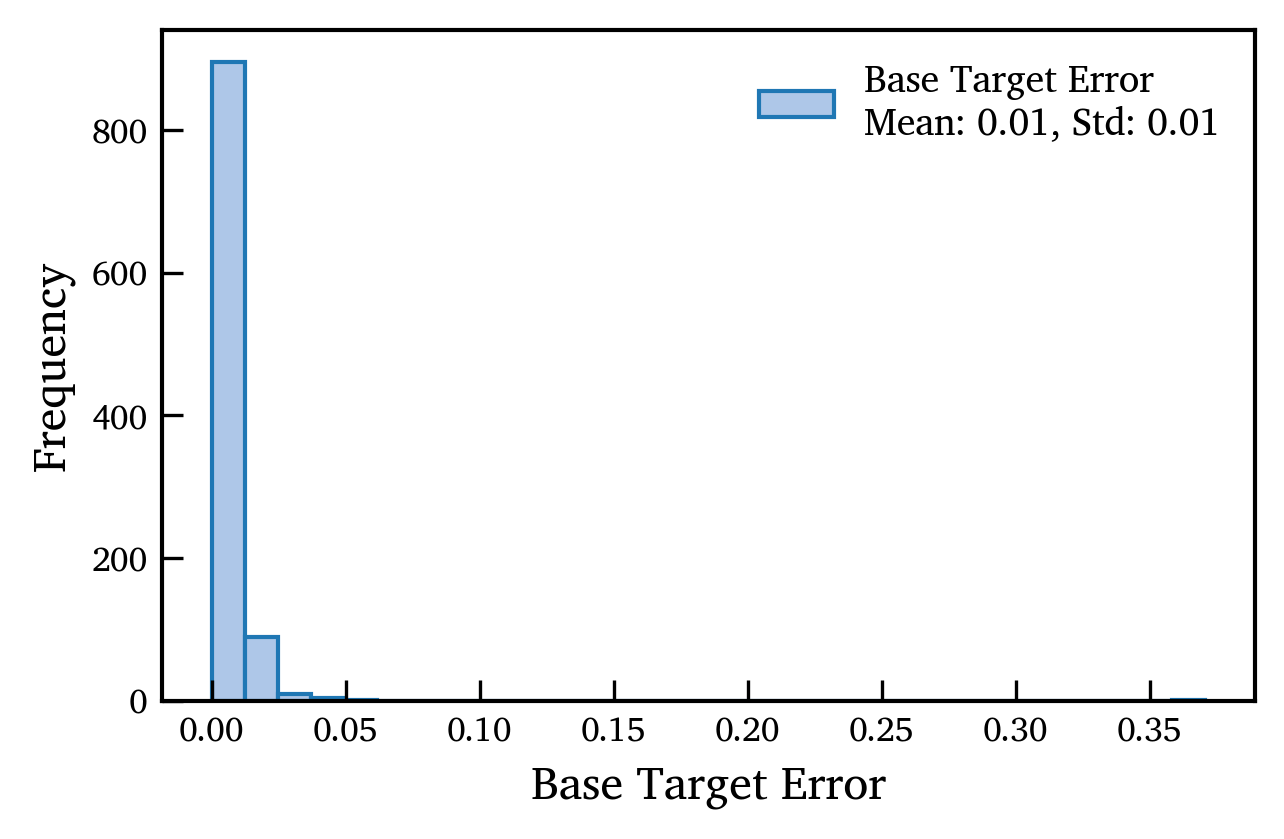

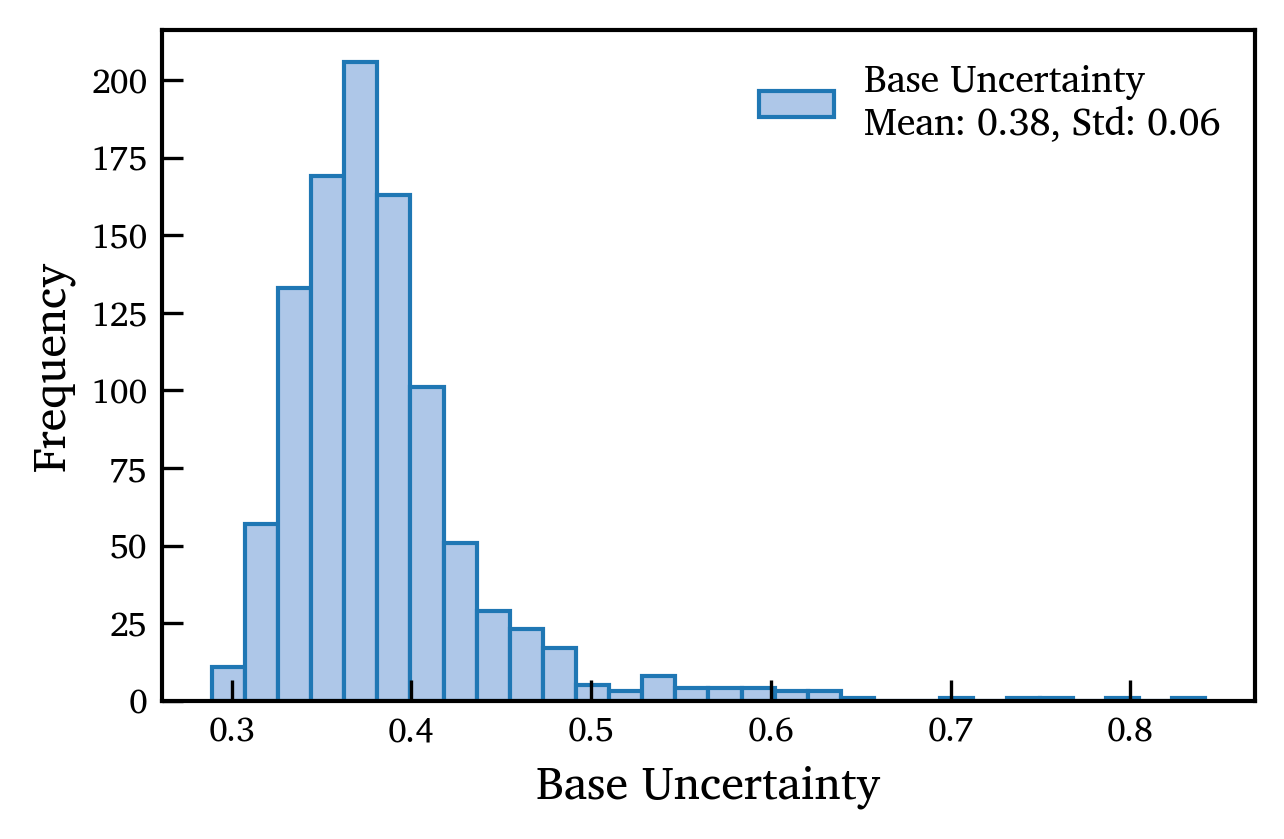

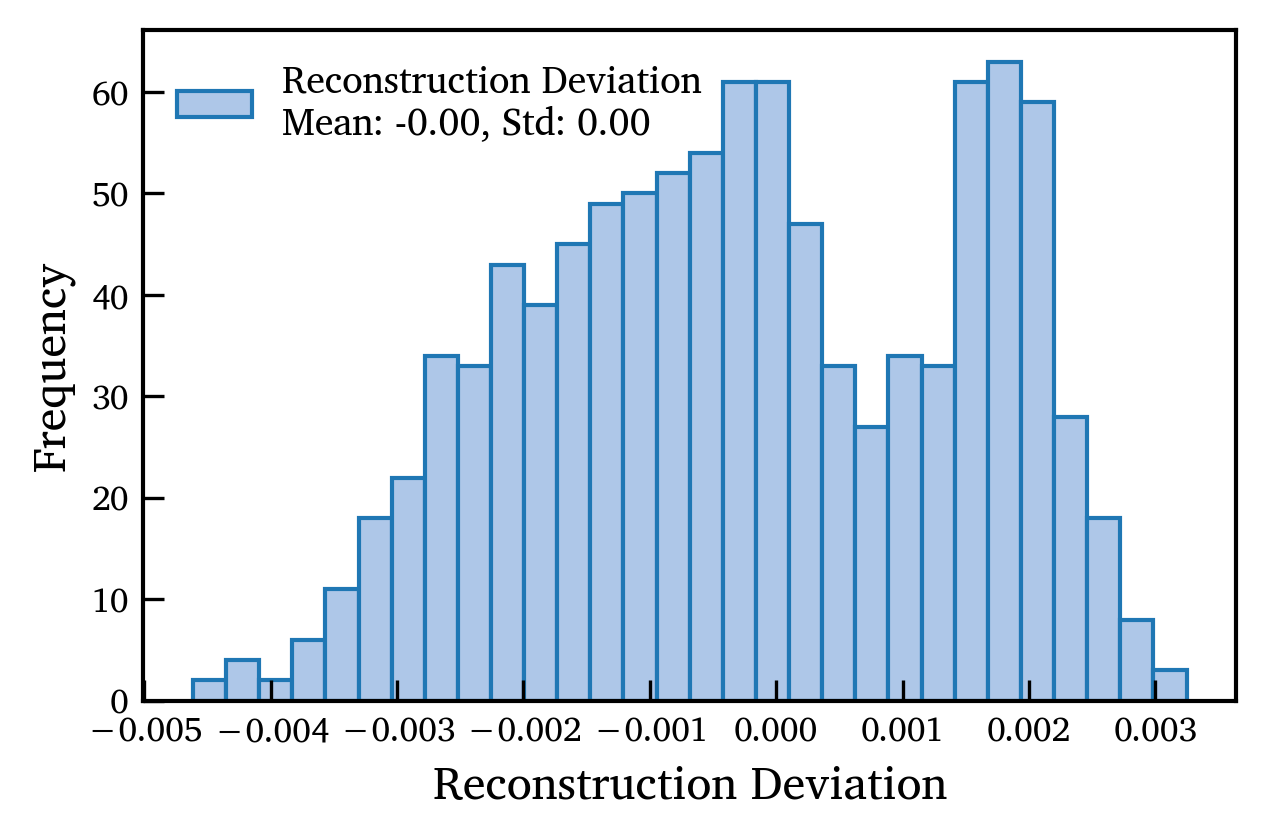

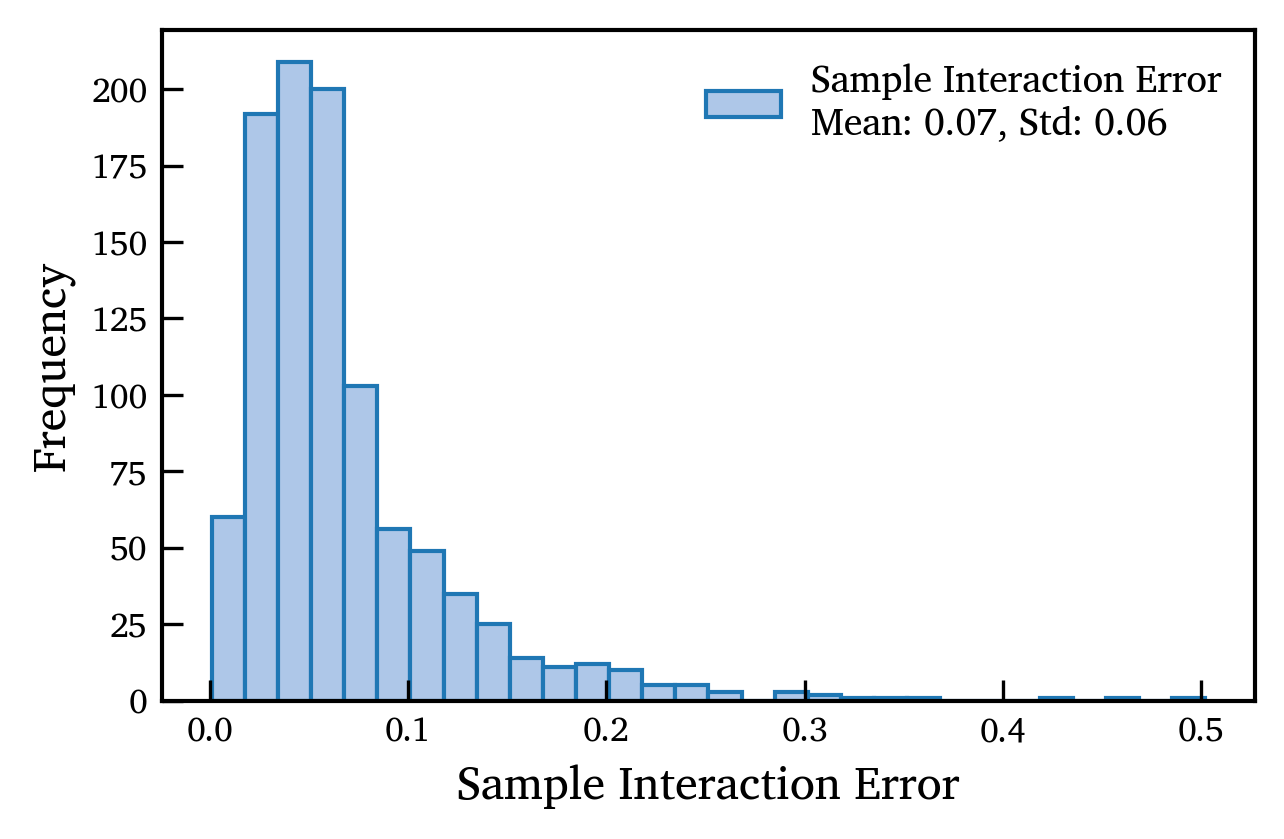

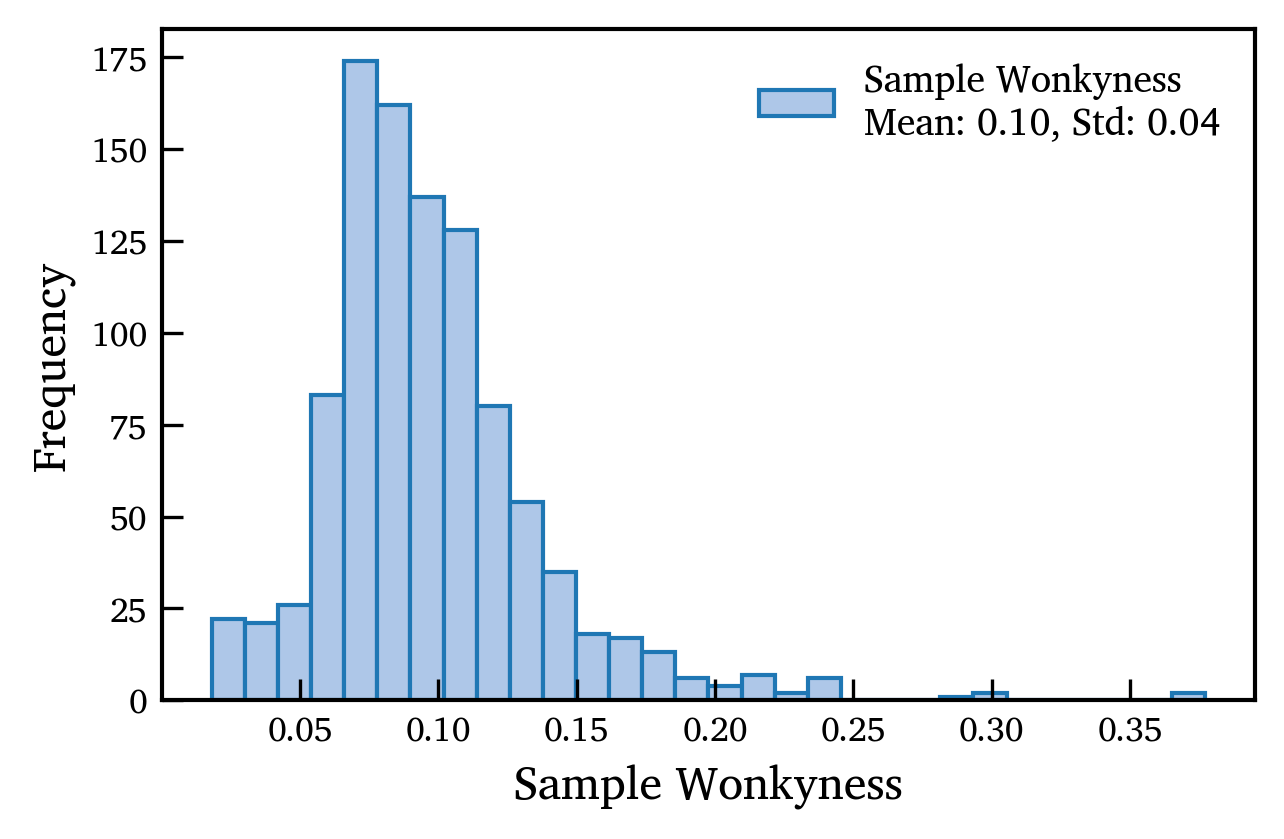

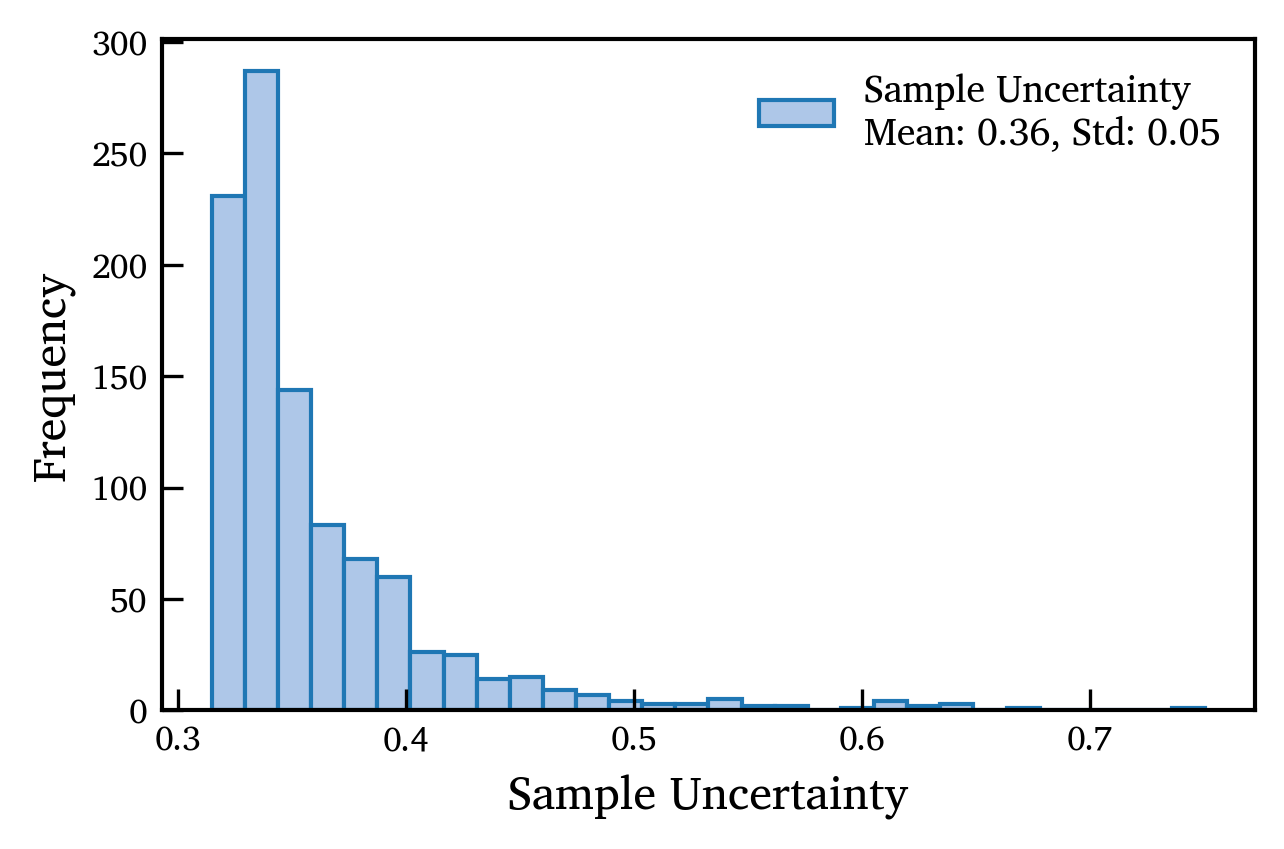

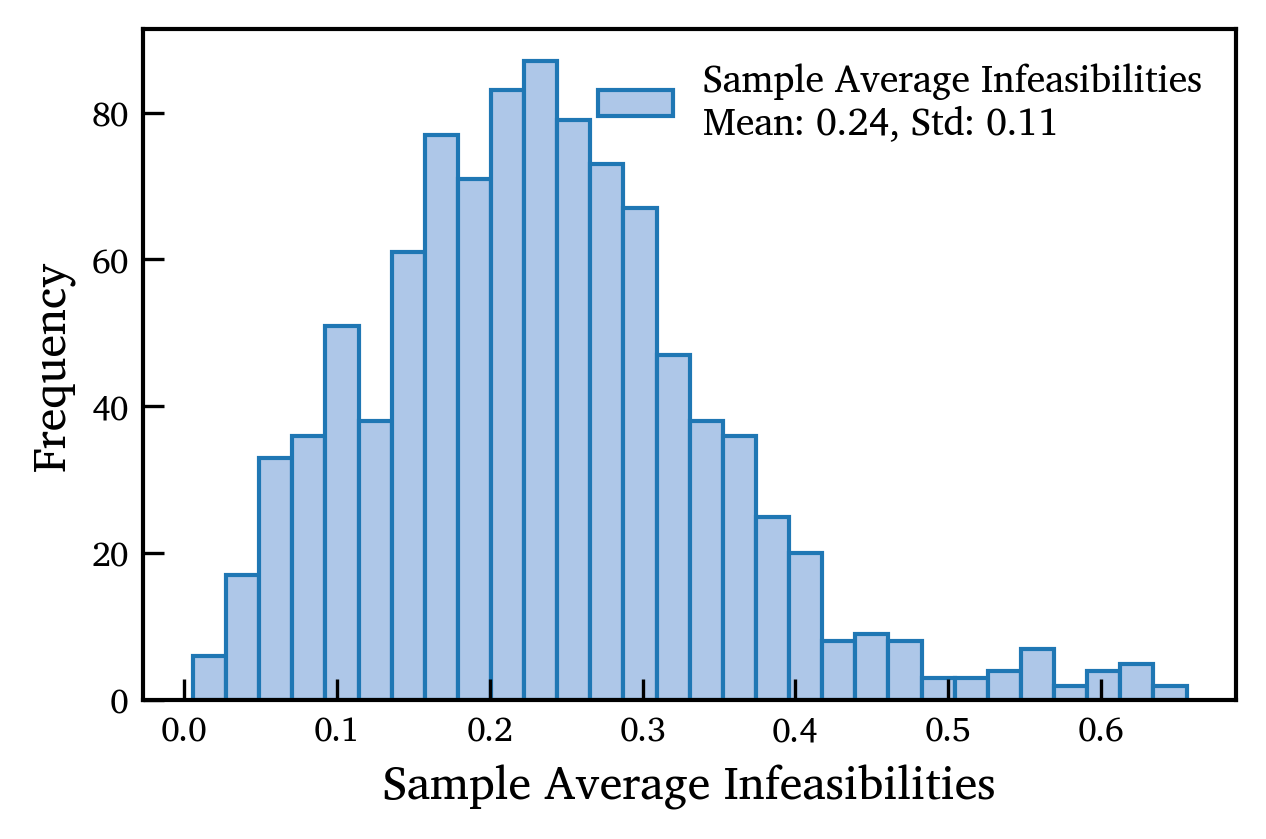

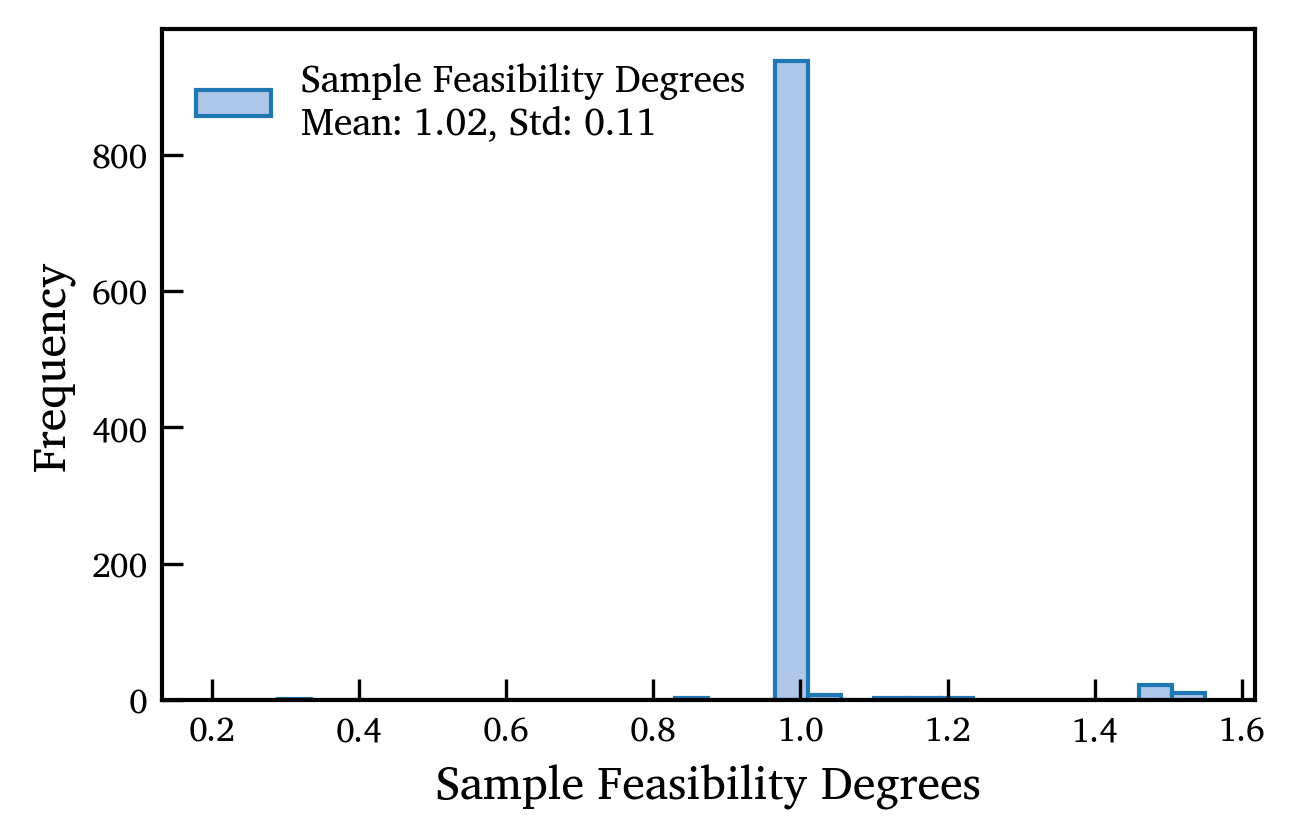

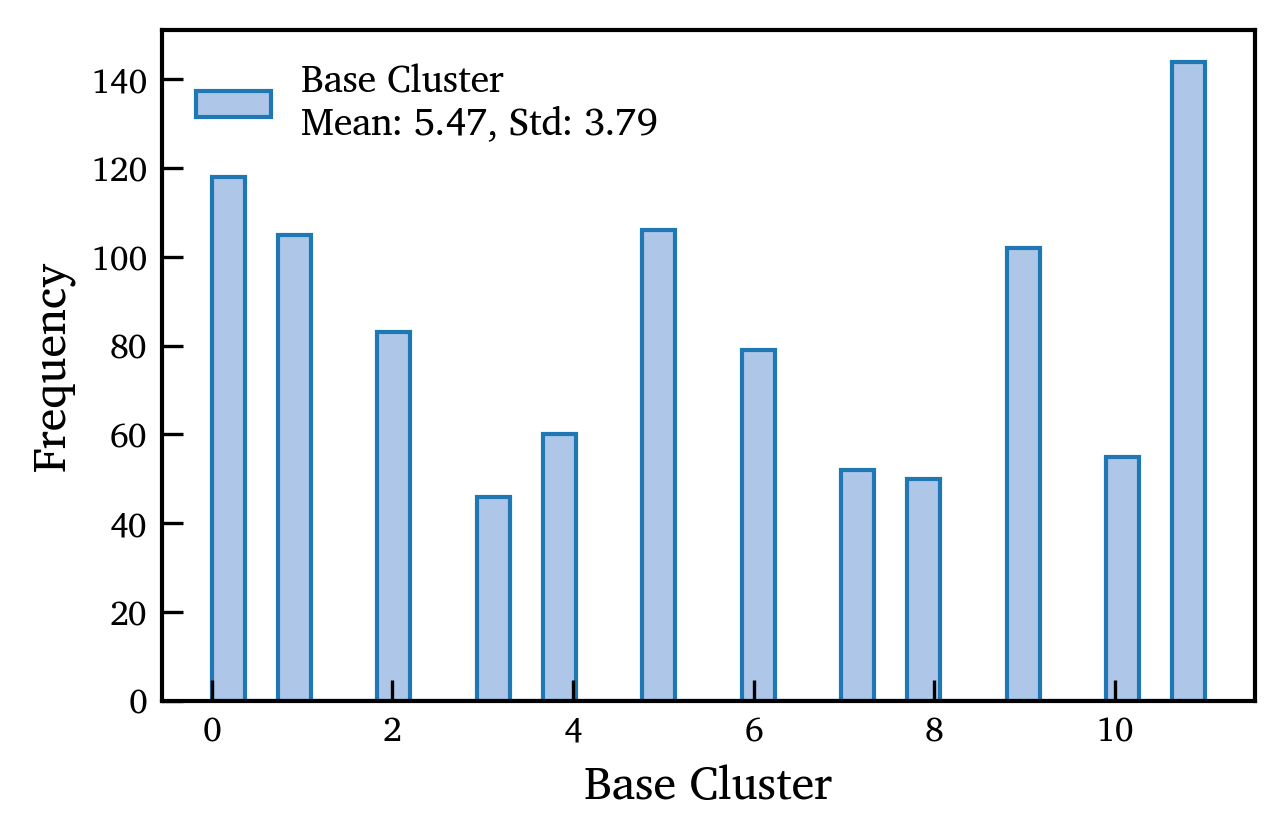

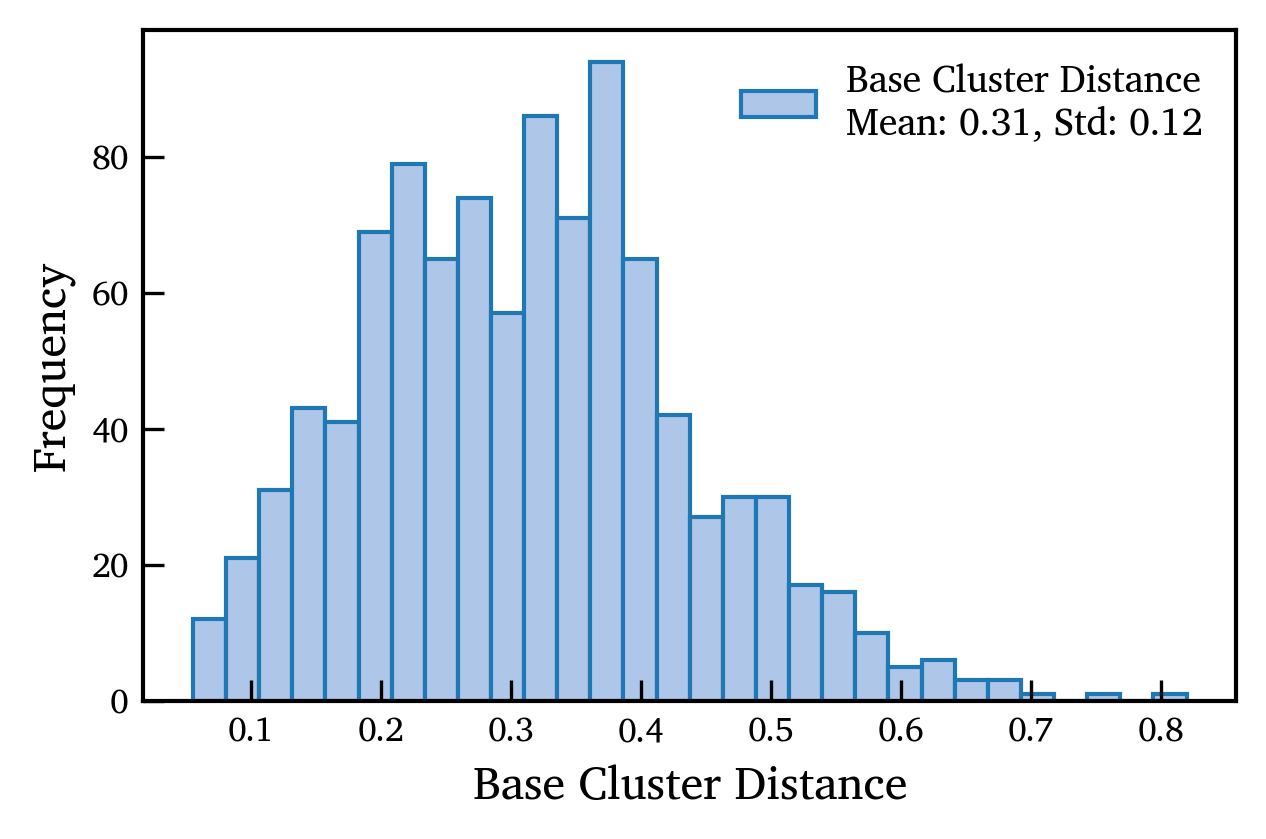

In [16]:
for error in columns:
    fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))
    ax.hist(error_summary[error], bins=30, 
            facecolor=plot_params.morecolors[1], 
            edgecolor=plot_params.morecolors[0],
            label=f'{error.replace("_", " ").title()}\nMean: {error_summary[error].mean():.2f}, Std: {error_summary[error].std():.2f}')

    ax.legend()
    ax.set_xlabel(error.replace("_", " ").title())
    ax.set_ylabel('Frequency')
    plt.show()

### Reconstruction Error

NameError: name 'reconstruction_deviation' is not defined

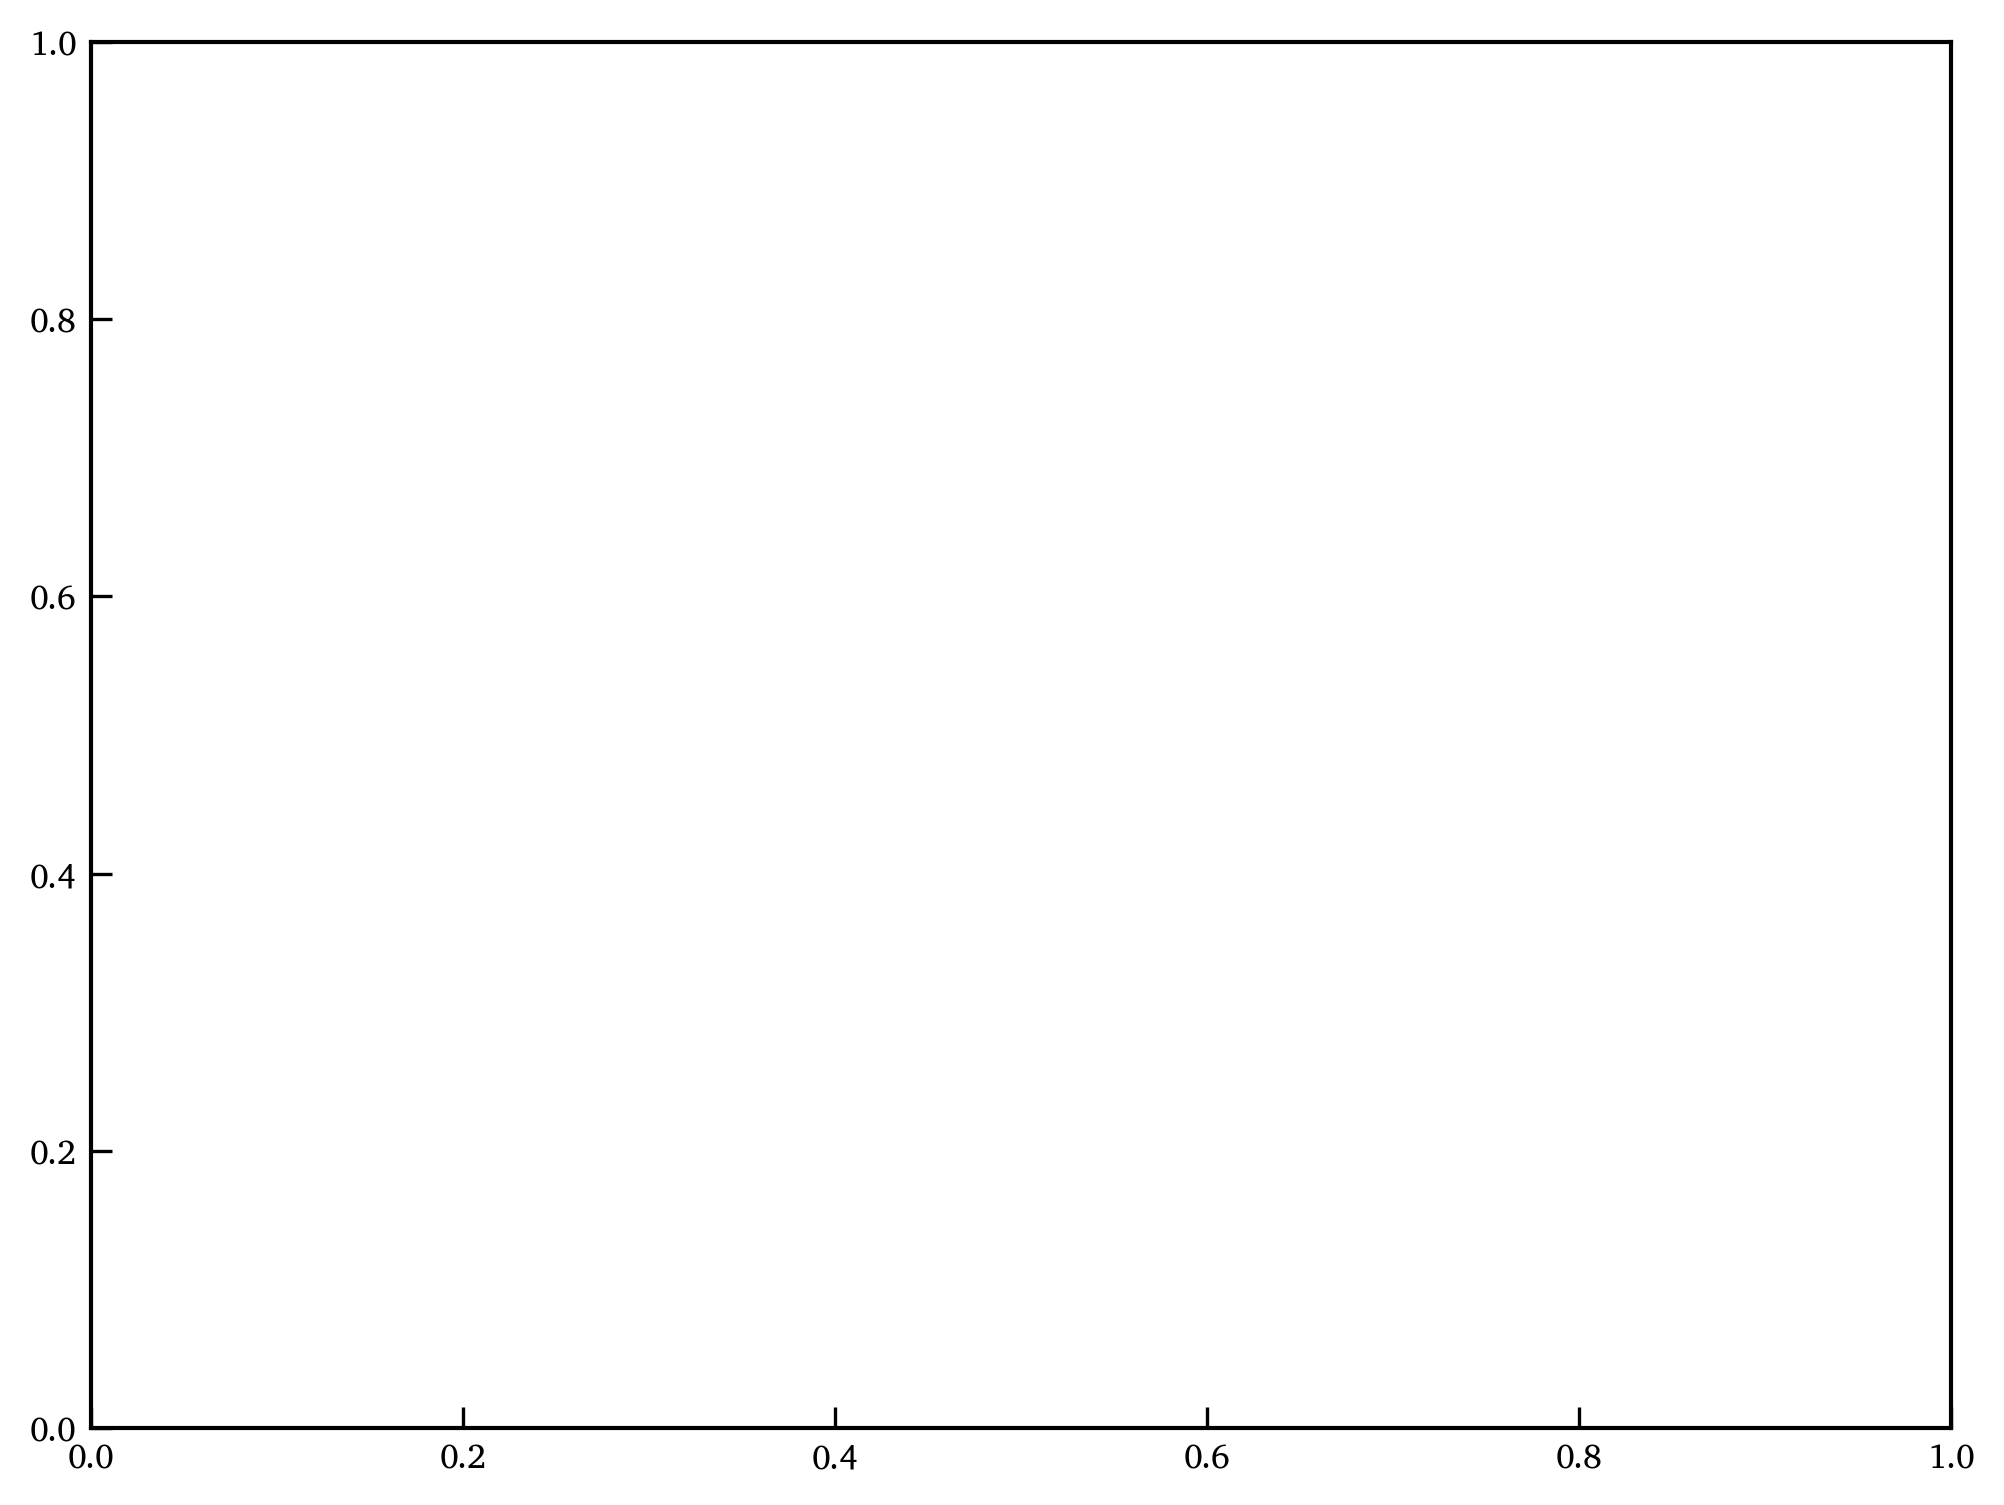

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

for i,feature in enumerate(features):
    error = reconstruction_deviation[:,i]

    error_bin_mean = error.mean()

    confidence = 50
    error_lower_val = np.percentile(error, (100 - confidence) / 2)
    error_upper_val = np.percentile(error, confidence + (100 - confidence) / 2)

    error_lower_bound = np.abs(error_bin_mean - error_lower_val)
    error_upper_bound = np.abs(error_upper_val - error_bin_mean)

    error_bounds = np.array([[error_lower_bound], [error_upper_bound]])

    ax.text(i-0.1, error_bin_mean-0.005, f"{error_bin_mean*100:.2f}+{error_upper_bound*100:.2f}-{error_lower_bound*100:.2f}%", ha='center', va='bottom', fontsize=10, color=plot_params.colors[3], rotation=90)
    ax.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', color=plot_params.colors[3], markersize=5, capsize=6)

ax.set_ylabel('Error / Max Value in Feature  [%]')
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=45)
ax.hlines(y=0, xmin=-0.5, xmax=len(features)-0.5, color='k', linestyle='--', label='Original')

plt.grid(True, axis='y', which='both', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

### Dependencies of metrics

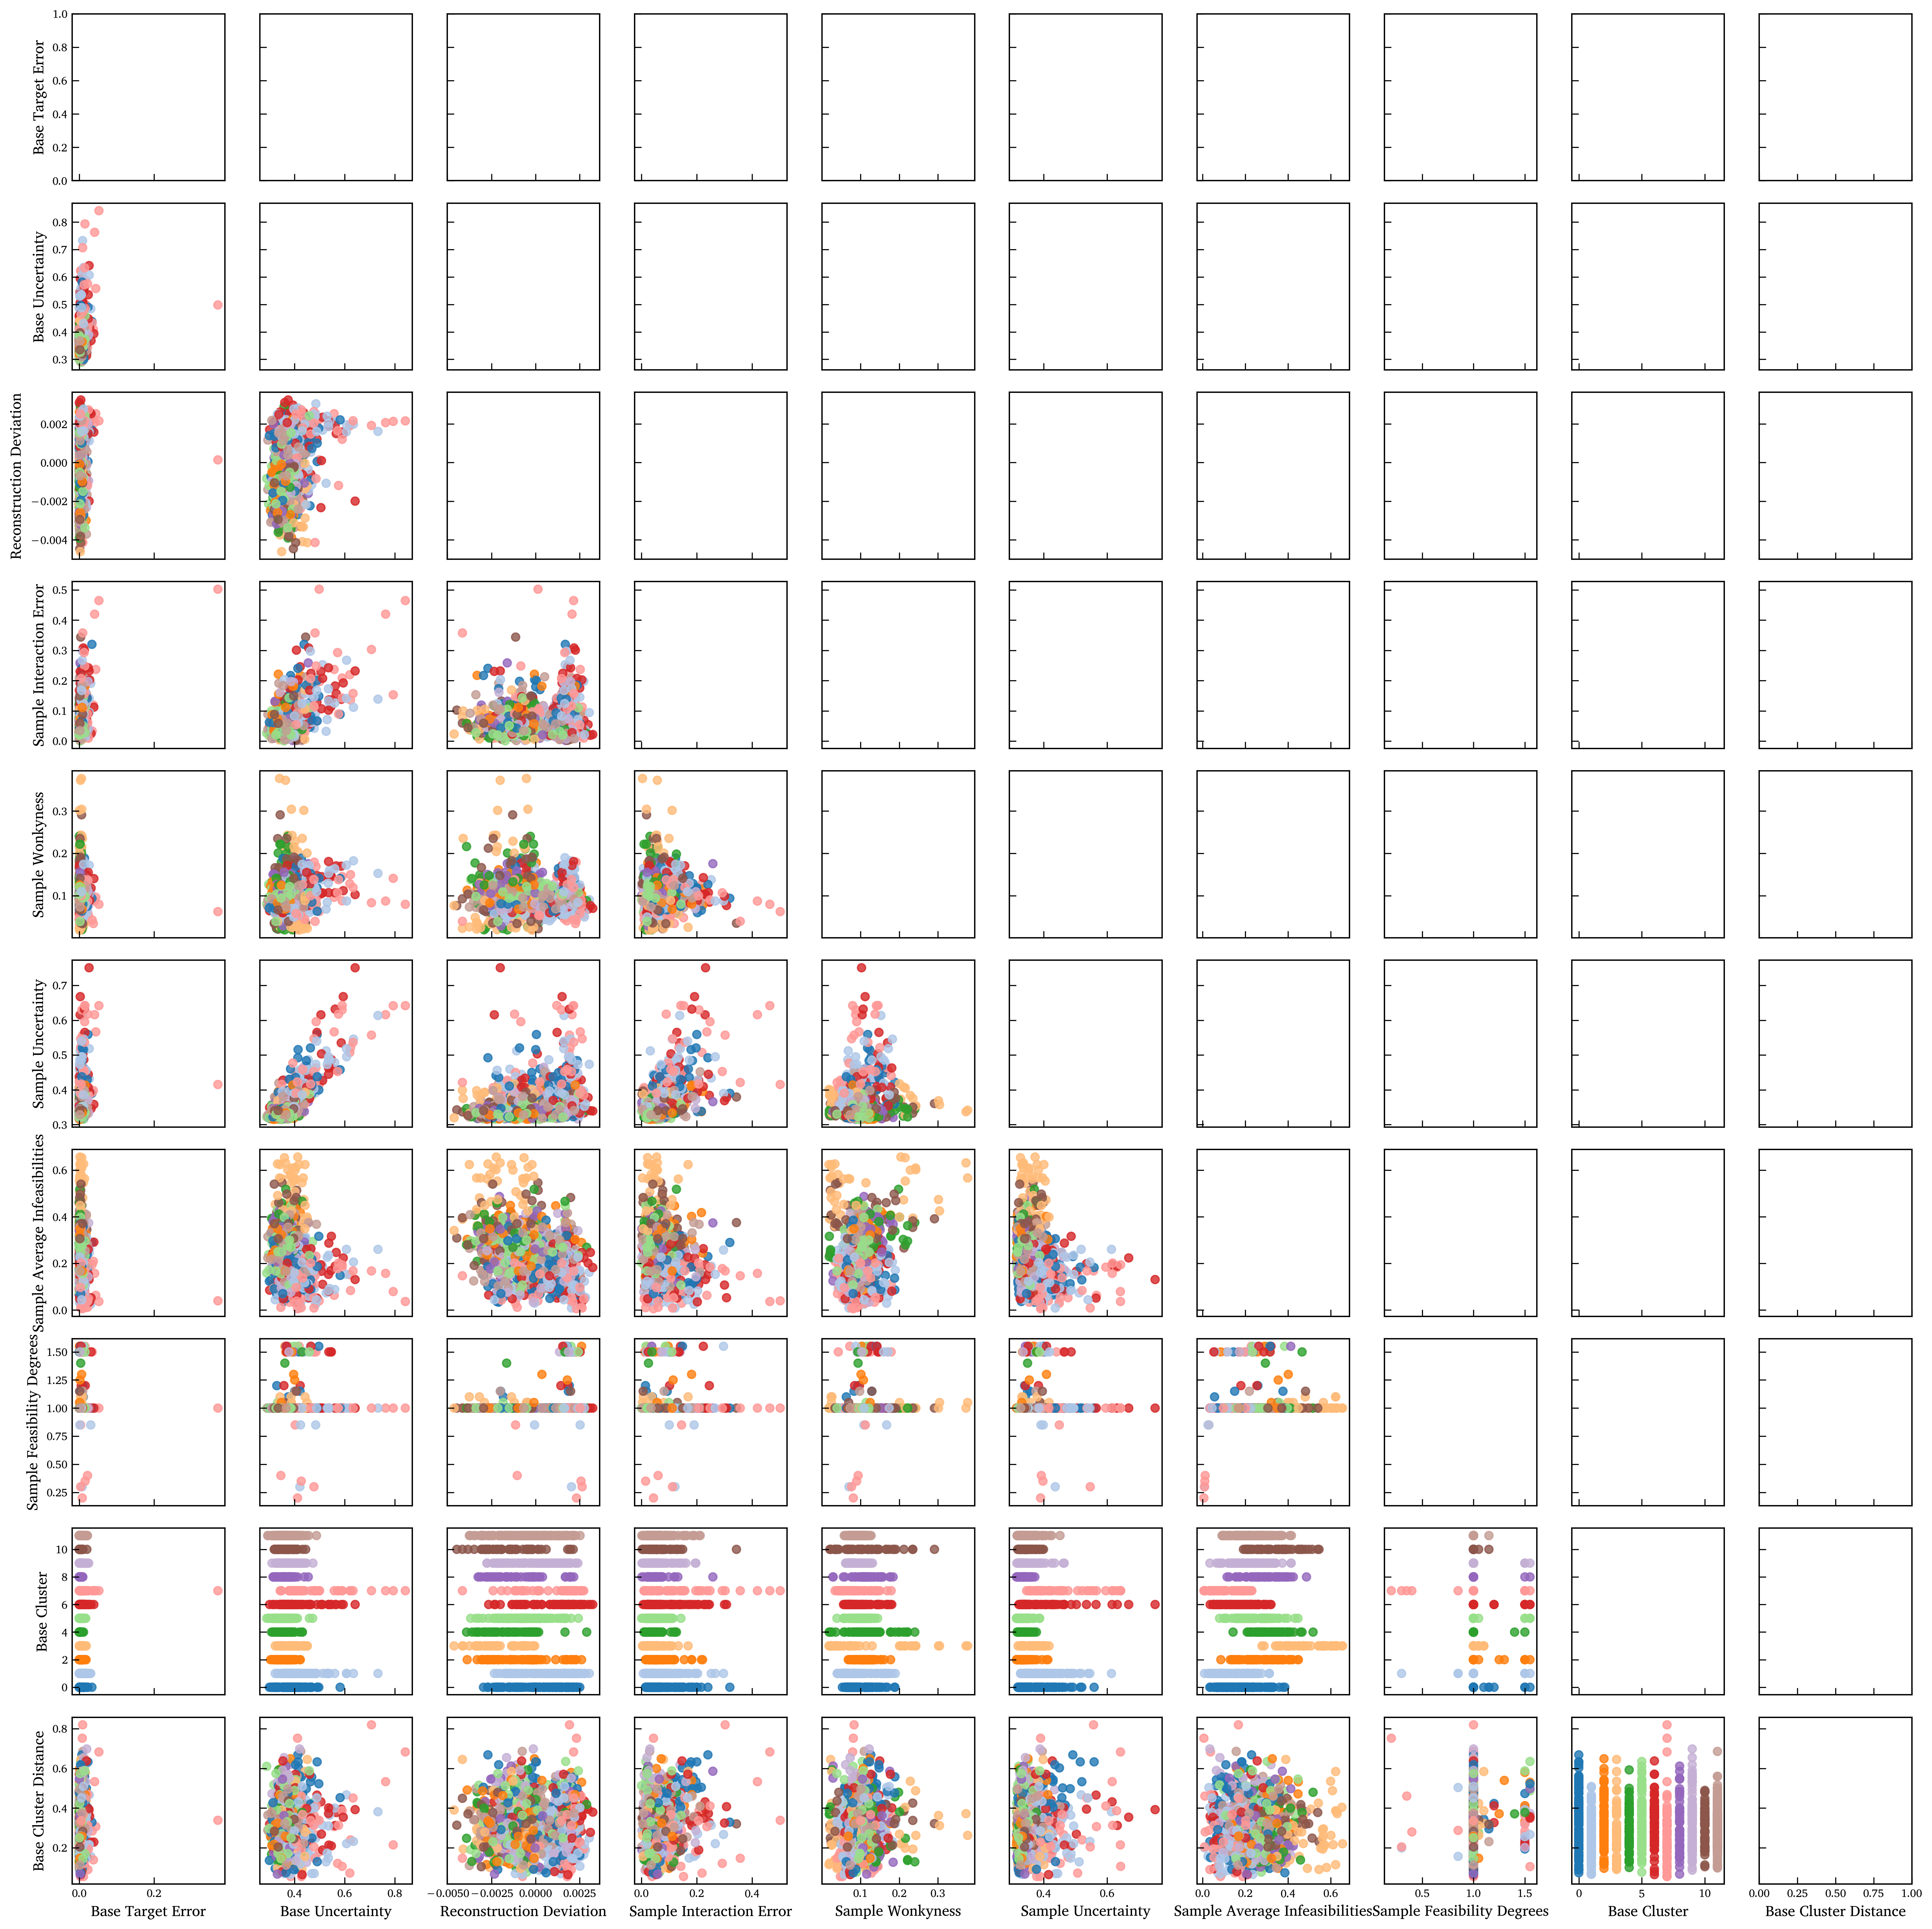

In [17]:
fig, axs = plt.subplots(len(columns), len(columns), figsize=(len(columns)*2, len(columns)*2), sharex='col', sharey='row')

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        ax = axs[j,i]
        ax.scatter(error_summary[columns[i]], error_summary[columns[j]], 
                   facecolor=colors,
                   edgecolor=colors,
                   alpha=0.8)

for i in range(len(columns)):
    ax = axs[i,0]
    ax.set_ylabel(columns[i].replace("_", " ").title())

    ax = axs[-1,i]
    ax.set_xlabel(columns[i].replace("_", " ").title())

plt.tight_layout()
plt.show()

### Correlations between metrics

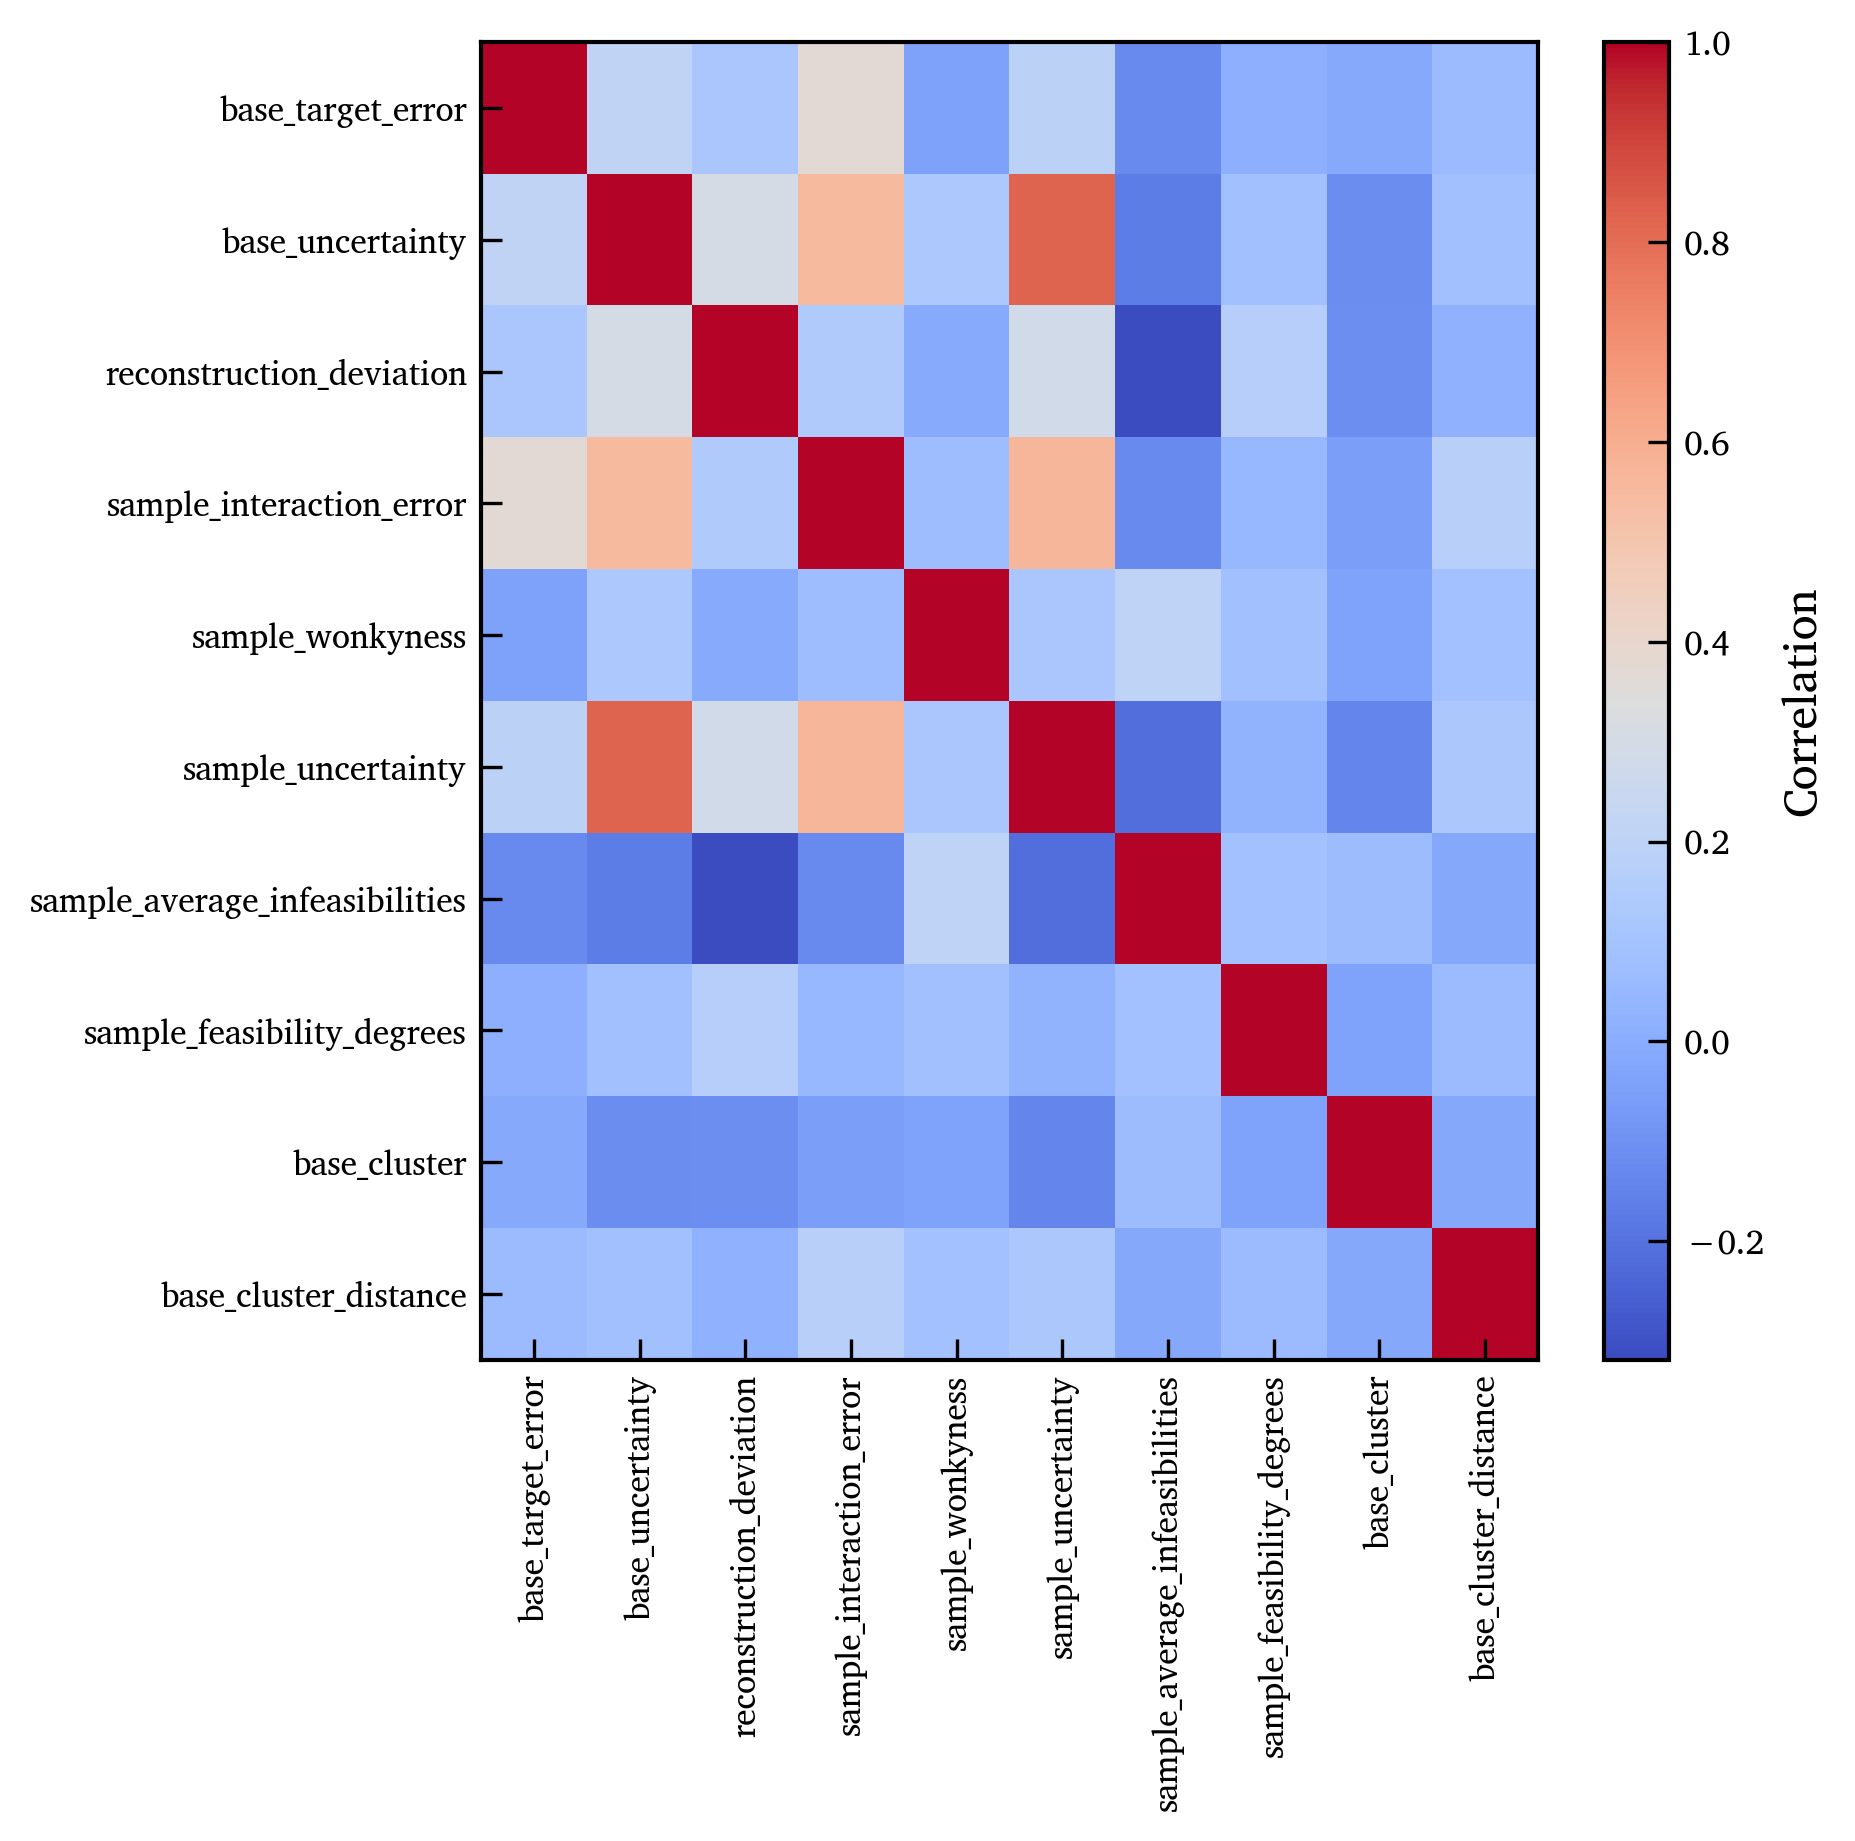

In [19]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1.0,1.0))
plt.imshow(error_summary.corr().values, aspect='auto', cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(ticks=np.arange(len(error_summary.columns)), labels=error_summary.columns, rotation=90)
plt.yticks(ticks=np.arange(len(error_summary.columns)), labels=error_summary.columns)
plt.tight_layout()
plt.show()

### Feature Importance

Which feature should be predicted by the others:

In [20]:
target_feature = 'base_target_error' #sample_interaction_error

In [21]:
ignore_features = [target_feature]
input_features = [col for col in columns if col not in ignore_features]

In [22]:
X = error_summary[input_features].astype(float)
y = error_summary[target_feature].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

importances = xgb.feature_importances_
xgb_features = X.columns
feature_importance = pd.Series(importances, index=xgb_features).sort_values(ascending=False)

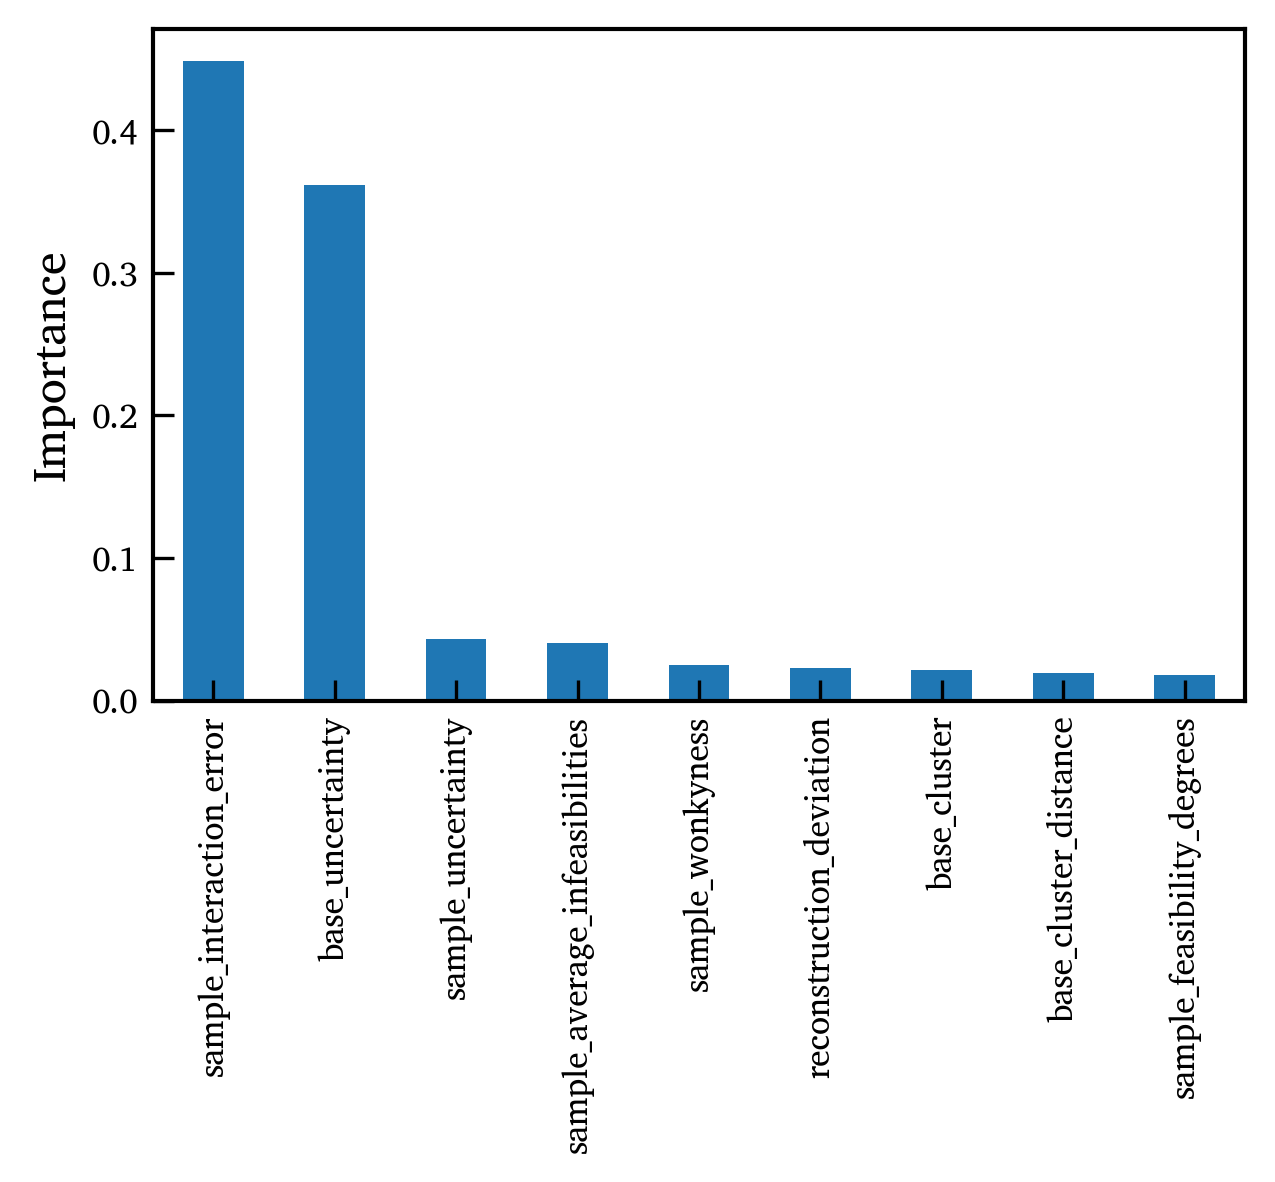

In [23]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

feature_importance.plot(kind='bar', ax=ax, color=plot_params.colors[0])

plt.ylabel('Importance')
plt.show()